# Q1 Gillespie's Direct Algorithm and Stochastic Hallmarks

Investigate
1. Variability
2. Negative co-variances
3. Increased transients
4. Stochastic resonance
5. Extinctions

In [14]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import scipy.stats as stats
from random import random
from os import listdir

\begin{align}
\frac{dS}{dt} &= \mu -\beta SI - \mu S, \label{eq:dSdtDemo} \\
\frac{dI}{dt} &= \beta SI - \gamma I- I(\mu + \rho), \label{eq:dIdtDemo} \\
\frac{dR}{dt} &= \gamma I- \mu R. \label{eq:dRdtDemo}
\end{align}

In [15]:
def determinsteSIR(previousState, t, beta, gamma, birth_rate):
    N = np.sum(previousState)
    state = np.empty(3)
    X,Y,Z = previousState
    state[0] = birth_rate - X*birth_rate - X*Y*beta
    state[1] = X*Y*beta   - Y*birth_rate - Y*gamma 
    state[2] = Y*gamma - Z*birth_rate
    return state
    

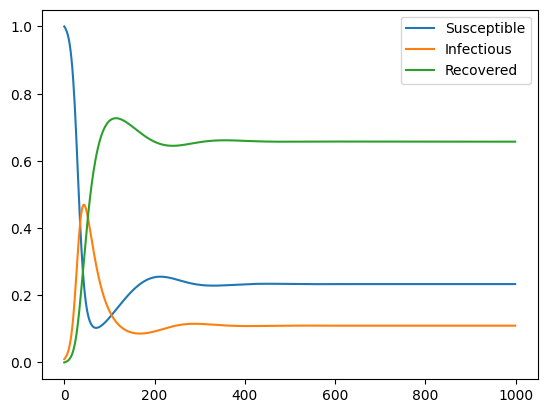

In [16]:
XYZ = [1, 0.01, 0]
t = np.linspace(0, 365, 1000)
beta = 1/2
gamma = 1/10
mu = 1/60

solved = odeint(determinsteSIR, XYZ, t, (beta, gamma, mu))
plt.plot(solved[:, 0], label = "Susceptible")
plt.plot(solved[:, 1], label = "Infectious")
plt.plot(solved[:, 2], label = "Recovered")
plt.legend(loc="best")

In [17]:
def stoch_sir(XYZ, N, tend, beta, gamma, mu):
    # Columns: SIR, Rows: Events [infect, recovery, birth, death S, death I, death R]
    change_matrix = np.array(
        [[-1, 1, 0],
         [0, -1, 1],
         [1,  0, 0],
         [-1, 0, 0],
         [0, -1, 0],
         [0,  0, -1]
         ])
    current_t = 0
    ts = 0.1
    T = [0]
    S = [XYZ[0]]
    I = [XYZ[1]]
    R = [XYZ[2]]

    while T[current_t] < tend:
        T.append(T[-1] + ts)
        S.append(XYZ[0])
        I.append(XYZ[1])
        R.append(XYZ[2])

        event_rates = ([(beta * XYZ[0] * XYZ[1])/N, gamma * XYZ[1],
                        mu * N,  mu * XYZ[0], mu * XYZ[1], mu * XYZ[2]])

        rand_1 = random()
        rand_2 = random()
        ts = -np.log(rand_1)/(np.sum(event_rates))

        p = rand_2 * np.sum(event_rates)
        event_index = min(np.nonzero(np.ravel(np.cumsum(event_rates) >= p))[0])

        XYZ = XYZ + change_matrix[event_index, :]

        current_t = current_t + 1
    return [T, S, I, R]


def run_simulations(number_of_runs, name, param, kwargs):
    for i in range(number_of_runs):
        df = pd.DataFrame(stoch_sir(**kwargs))
        for column in kwargs.keys():
            df[column] = [kwargs[column] for x in range(len(df))]
        df["group"] = ["S", "I", "R"]
        df.to_csv(f"seeddata/{name.capitalize()}{param:.2f}stochasticSIR{i+1}.csv", index=False)


[T, S, I, R] = stoch_sir(XYZ)

data_T = np.array(T)
data_S = np.array(S)/10000
data_I = np.array(I)/10000
data_R = np.array(R)/10000

data_T = np.array(T)
data_S = np.array(S)/10000
data_I = np.array(I)/10000
data_R = np.array(R)/10000

plt.plot(data_T, data_S, data_T, data_I, data_T, data_R)
plt.xlabel("Days")
plt.ylabel("Population Fraction")
plt.legend(["Susceptible", "Infected", "Recovered"])
plt.show()


TypeError: stoch_sir() missing 5 required positional arguments: 'N', 'tend', 'beta', 'gamma', and 'mu'

## Investigate Simulation variability and Negative Co-variance

> Investigate how varying the model parameters changes the behavior of the stochastic dynamics. How do the related to the variance between runs and the negative covariance between $S$ and $I$.

> Compare the mean of the stochatic models to their deterministic counter parts

In [30]:
#Reading in data from files

dfs_1 = []
dfs_2 = []
dfs_3 = []
dfs_4 = []

for i in range(1, 11):
    df1 = pd.read_csv(f"seeddata/Beta0.5gamma0.1_0.02stochasticSIR{i}.csv")
    df2 = pd.read_csv(f"seeddata/Beta0.5gamma0.01_0.02stochasticSIR{i}.csv")
    df3 = pd.read_csv(f"seeddata/Beta0.05gamma0.1_0.005stochasticSIR{i}.csv")
    df4 = pd.read_csv(f"seeddata/Beta0.05gamma0.01_0.005stochasticSIR{i}.csv")
    
    dfs_1.append(df1)
    dfs_2.append(df2)
    dfs_3.append(df3)
    dfs_4.append(df4)

concat_df_1 = pd.concat(dfs_1)/10000
concat_df_row_1 = concat_df_1.groupby(level = 0)
df_means_1 = concat_df_row_1.mean()

concat_df_2 = pd.concat(dfs_2)/10000
concat_df_row_2 = concat_df_2.groupby(level = 0)
df_means_2 = concat_df_row_2.mean()

concat_df_3 = pd.concat(dfs_3)/10000
concat_df_row_3 = concat_df_3.groupby(level = 0)
df_means_3 = concat_df_row_3.mean()

concat_df_4 = pd.concat(dfs_4)/10000
concat_df_row_4 = concat_df_4.groupby(level = 0)
df_means_4 = concat_df_row_4.mean()

Covariance between S and I - beta = 1/2, gamma = 1/10: 
-0.002968414950771105
Covariance between S and I - beta = 1/2, gamma = 1/100: 
-0.02250588902953612
Covariance between S and I - beta = 1/200, gamma = 1/10: 
-5.621704307591589e-09
Covariance between S and I - beta = 1/200, gamma = 1/100: 
-8.552669678226976e-05


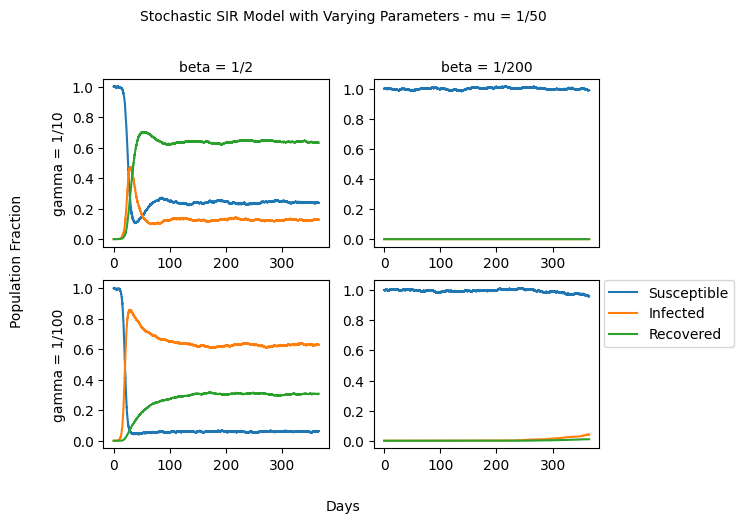

In [29]:
df1 = pd.read_csv(f"seeddata/Beta0.5gamma0.1_0.02stochasticSIR2.csv")
df2 = pd.read_csv(f"seeddata/Beta0.5gamma0.01_0.02stochasticSIR2.csv")
df3 = pd.read_csv(f"seeddata/Beta0.05gamma0.1_0.02stochasticSIR2.csv")
df4 = pd.read_csv(f"seeddata/Beta0.05gamma0.01_0.02stochasticSIR2.csv")

fig, axs = plt.subplots(2, 2)

cov = np.cov(df1["S"]/10000, df1["I"]/10000)
print("Covariance between S and I - beta = 1/2, gamma = 1/10: ")
print(cov[0,1])

cov = np.cov(df2["S"]/10000, df2["I"]/10000)
print("Covariance between S and I - beta = 1/2, gamma = 1/100: ")
print(cov[0,1])

cov = np.cov(df3["S"]/10000, df3["I"]/10000)
print("Covariance between S and I - beta = 1/200, gamma = 1/10: ")
print(cov[0,1])

cov = np.cov(df4["S"]/10000, df4["I"]/10000)
print("Covariance between S and I - beta = 1/200, gamma = 1/100: ")
print(cov[0,1])


axs[0, 0].plot(df1["T"], df1["S"]/10000, df1["T"], df1["I"]/10000, df1["T"], df1["R"]/10000)
axs[0, 0].set_title("beta = 1/2", fontsize = 10)
axs[0, 0].set_ylabel("gamma = 1/10")
axs[1, 0].plot(df2["T"], df2["S"]/10000, df2["T"], df2["I"]/10000, df2["T"], df2["R"]/10000)
axs[1, 0].set_ylabel("gamma = 1/100")
axs[0, 1].plot(df3["T"], df3["S"]/10000, df3["T"], df3["I"]/10000, df3["T"], df3["R"]/10000)
axs[0, 1].set_title("beta = 1/20", fontsize = 10)
axs[1, 1].plot(df4["T"], df4["S"]/10000, df4["T"], df4["I"]/10000, df4["T"], df4["R"]/10000)

fig.text(0.5, -0.01, "Days", ha='center', va='center')
fig.text(-0.01, 0.5, "Population Fraction", ha='center', va='center', rotation='vertical')
fig.text(0.5, 1.01, "Stochastic SIR Model with Varying Parameters - mu = 1/50", ha='center', va='center', rotation='horizontal')
plt.legend(["Susceptible", "Infected", "Recovered"], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)



Covariance between S and I - beta = 1/2, gamma = 1/10: 
0.0005094570906593468
Covariance between S and I - beta = 1/2, gamma = 1/100: 
-0.017982502430620825
Covariance between S and I - beta = 1/200, gamma = 1/10: 
3.0735996520562584e-08
Covariance between S and I - beta = 1/200, gamma = 1/100: 
-0.04940753392378884


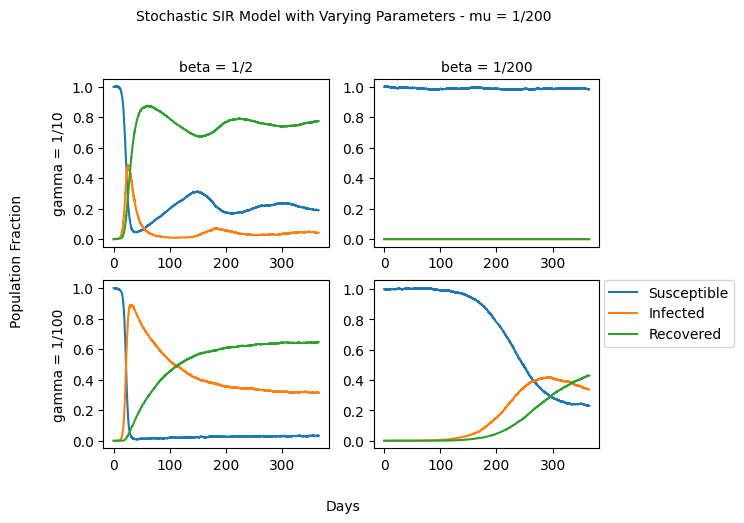

In [37]:
df1 = pd.read_csv(f"seeddata/Beta0.5gamma0.1_0.005stochasticSIR2.csv")
df2 = pd.read_csv(f"seeddata/Beta0.5gamma0.01_0.005stochasticSIR2.csv")
df3 = pd.read_csv(f"seeddata/Beta0.05gamma0.1_0.005stochasticSIR2.csv")
df4 = pd.read_csv(f"seeddata/Beta0.05gamma0.01_0.005stochasticSIR2.csv")

fig, axs = plt.subplots(2, 2)

cov = np.cov(df1["S"]/10000, df1["I"]/10000)
print("Covariance between S and I - beta = 1/2, gamma = 1/10: ")
print(cov[0,1])

cov = np.cov(df2["S"]/10000, df2["I"]/10000)
print("Covariance between S and I - beta = 1/2, gamma = 1/100: ")
print(cov[0,1])

cov = np.cov(df3["S"]/10000, df3["I"]/10000)
print("Covariance between S and I - beta = 1/200, gamma = 1/10: ")
print(cov[0,1])

cov = np.cov(df4["S"]/10000, df4["I"]/10000)
print("Covariance between S and I - beta = 1/200, gamma = 1/100: ")
print(cov[0,1])


axs[0, 0].plot(df1["T"], df1["S"]/10000, df1["T"], df1["I"]/10000, df1["T"], df1["R"]/10000)
axs[0, 0].set_title("beta = 1/2", fontsize = 10)
axs[0, 0].set_ylabel("gamma = 1/10")
axs[1, 0].plot(df2["T"], df2["S"]/10000, df2["T"], df2["I"]/10000, df2["T"], df2["R"]/10000)
axs[1, 0].set_ylabel("gamma = 1/100")
axs[0, 1].plot(df3["T"], df3["S"]/10000, df3["T"], df3["I"]/10000, df3["T"], df3["R"]/10000)
axs[0, 1].set_title("beta = 1/20", fontsize = 10)
axs[1, 1].plot(df4["T"], df4["S"]/10000, df4["T"], df4["I"]/10000, df4["T"], df4["R"]/10000)

fig.text(0.5, -0.01, "Days", ha='center', va='center')
fig.text(-0.01, 0.5, "Population Fraction", ha='center', va='center', rotation='vertical')
fig.text(0.5, 1.01, "Stochastic SIR Model with Varying Parameters - mu = 1/200", ha='center', va='center', rotation='horizontal')
plt.legend(["Susceptible", "Infected", "Recovered"], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)



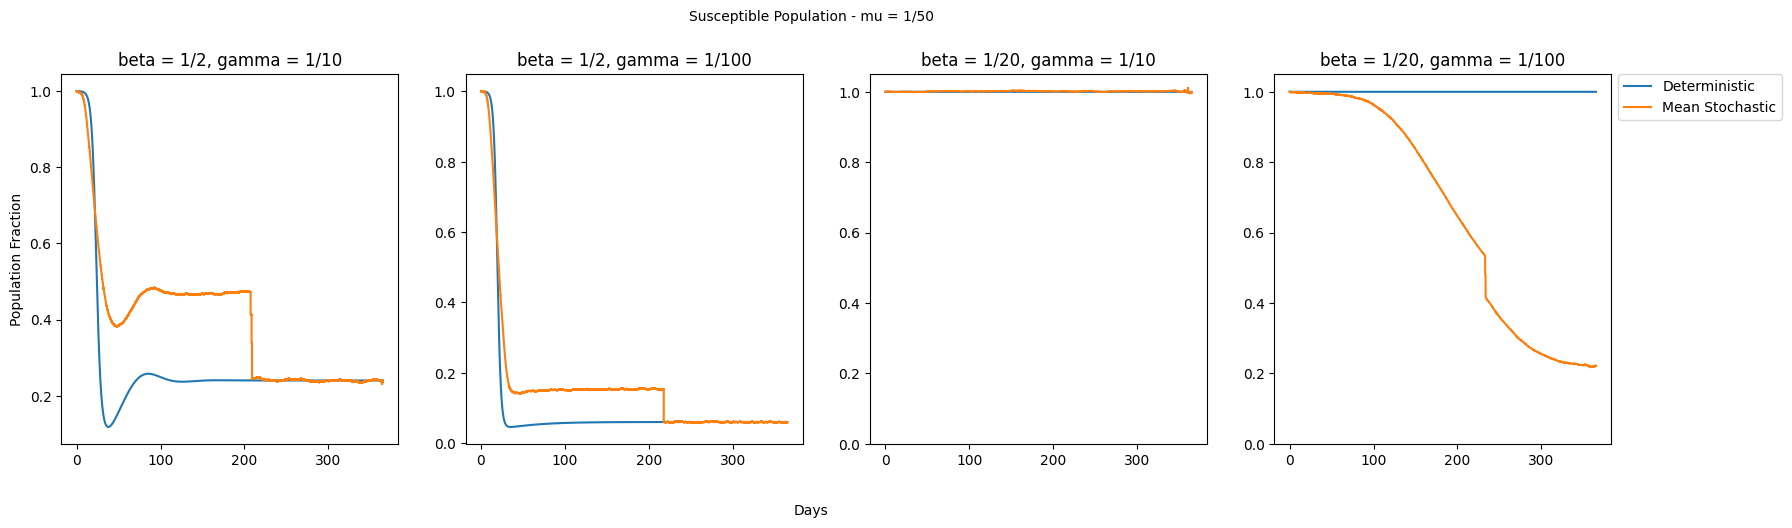

In [56]:
#I was dumb before. We need to compare the output from the deterministic model with the average
#from the stochastic model. 

#For susceptibles across parameter conditions

fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 1, 1, 1]})

fig.set_figwidth(20)

XYZ = [1, 0.0001, 0]
t1 = np.linspace(0, 365, 255988)
beta = 1/2
gamma = 1/10
birth_rate = 1/50

solved1 = odeint(determinsteSIR, XYZ, t1, (beta, gamma, birth_rate))

XYZ = [1, 0.0001, 0]
t2 = np.linspace(0, 365, 244847)
beta = 1/2
gamma = 1/100
birth_rate = 1/50

solved2 = odeint(determinsteSIR, XYZ, t2, (beta, gamma, birth_rate))

XYZ = [1, 0.0001, 0]
t3 = np.linspace(0, 365, 37131)
beta = 1/200
gamma = 1/10
birth_rate = 1/50

solved3 = odeint(determinsteSIR, XYZ, t3, (beta, gamma, birth_rate))

XYZ = [1, 0.0001, 0]
t4 = np.linspace(0, 365, 57175)
beta = 1/200
gamma = 1/100
birth_rate = 1/50

solved4 = odeint(determinsteSIR, XYZ, t4, (beta, gamma, birth_rate))

axs[0].plot(t1, solved1[:,0], t1, df_means_1["S"])
axs[0].set_title("beta = 1/2, gamma = 1/10")
axs[0].set_ylabel("Population Fraction")
axs[1].plot(t2, solved2[:,0], t2, df_means_2["S"])
axs[1].set_title("beta = 1/2, gamma = 1/100")
axs[2].plot(t3, solved3[:,0], t3, df_means_3["S"])
axs[2].set_title("beta = 1/20, gamma = 1/10")
axs[2].set_ylim([0,1.05])
axs[3].plot(t4, solved4[:,0], t4, df_means_4["S"])
axs[3].set_title("beta = 1/20, gamma = 1/100")
axs[3].set_ylim([0,1.05])


fig.text(0.5, -0.03, "Days", ha='center', va='center')
fig.text(0.5, 1.0, "Susceptible Population - mu = 1/50", ha='center', va='center', rotation='horizontal')
plt.subplots_adjust(wspace = 0.2)
plt.legend(["Deterministic", "Mean Stochastic"], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

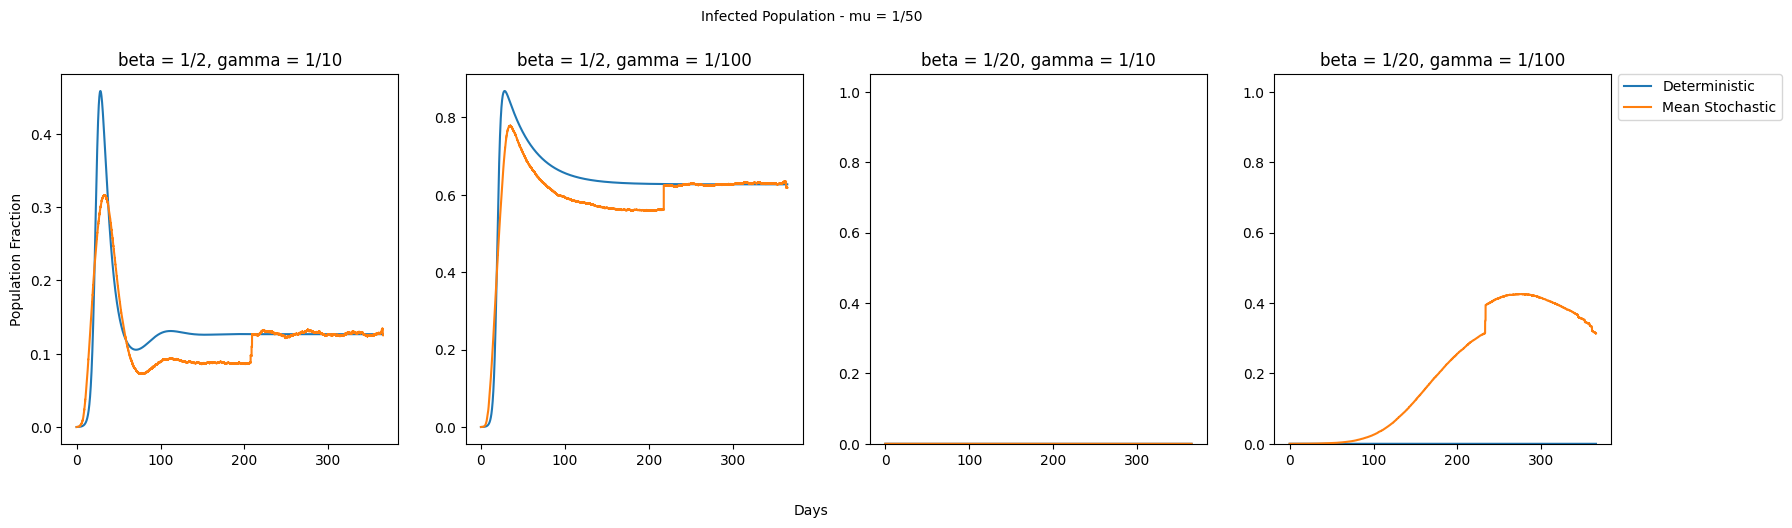

In [57]:
#Comparing deterministic to average stochastic - Infecteds

fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 1, 1, 1]})

fig.set_figwidth(20)

axs[0].plot(t1, solved1[:,1], t1, df_means_1["I"])
axs[0].set_ylabel("Population Fraction")
axs[1].plot(t2, solved2[:,1], t2, df_means_2["I"])
axs[2].plot(t3, solved3[:,1], t3, df_means_3["I"])
axs[2].set_ylim([0,1.05])
axs[3].plot(t4, solved4[:,1], t4, df_means_4["I"])
axs[3].set_ylim([0,1.05])
axs[0].set_title("beta = 1/2, gamma = 1/10")
axs[1].set_title("beta = 1/2, gamma = 1/100")
axs[2].set_title("beta = 1/20, gamma = 1/10")
axs[3].set_title("beta = 1/20, gamma = 1/100")


fig.text(0.5, -0.03, "Days", ha='center', va='center')
fig.text(0.5, 1.0, "Infected Population - mu = 1/50", ha='center', va='center', rotation='horizontal')
plt.subplots_adjust(wspace = 0.2)
plt.legend(["Deterministic", "Mean Stochastic"], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

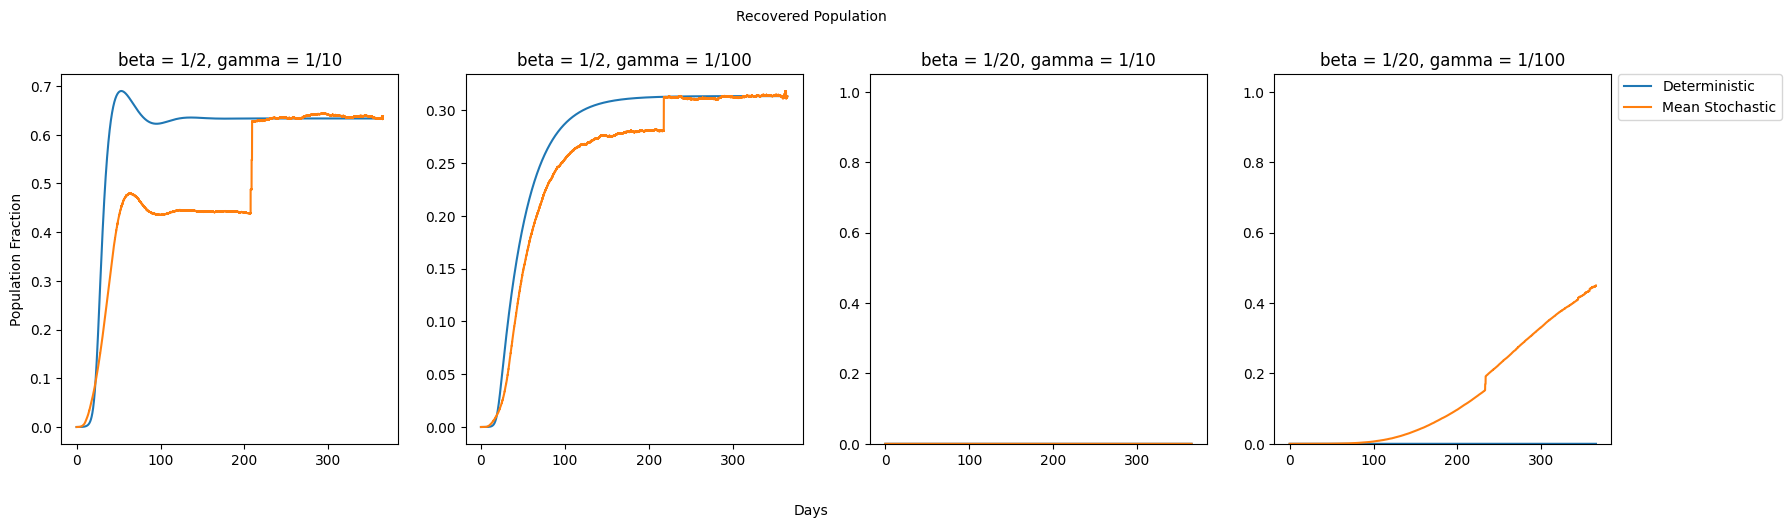

In [58]:
#Comparing deterministic to stochastic - recovereds

fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 1, 1, 1]})

fig.set_figwidth(20)

axs[0].plot(t1, solved1[:,2], t1, df_means_1["R"])
axs[0].set_title("beta = 1/2, gamma = 1/10")
axs[0].set_ylabel("Population Fraction")
axs[1].plot(t2, solved2[:,2], t2, df_means_2["R"])
axs[1].set_title("beta = 1/2, gamma = 1/100")
axs[2].plot(t3, solved3[:,2], t3, df_means_3["R"])
axs[2].set_title("beta = 1/200, gamma = 1/10")
axs[2].set_ylim([0,1.05])
axs[3].plot(t4, solved4[:,2], t4, df_means_4["R"])
axs[3].set_title("beta = 1/200, gamma = 1/100")
axs[3].set_ylim([0,1.05])
axs[0].set_title("beta = 1/2, gamma = 1/10")
axs[1].set_title("beta = 1/2, gamma = 1/100")
axs[2].set_title("beta = 1/20, gamma = 1/10")
axs[3].set_title("beta = 1/20, gamma = 1/100")


fig.text(0.5, -0.03, "Days", ha='center', va='center')
fig.text(0.5, 1.0, "Recovered Population", ha='center', va='center', rotation='horizontal')
plt.subplots_adjust(wspace = 0.2)
plt.legend(["Deterministic", "Mean Stochastic"], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

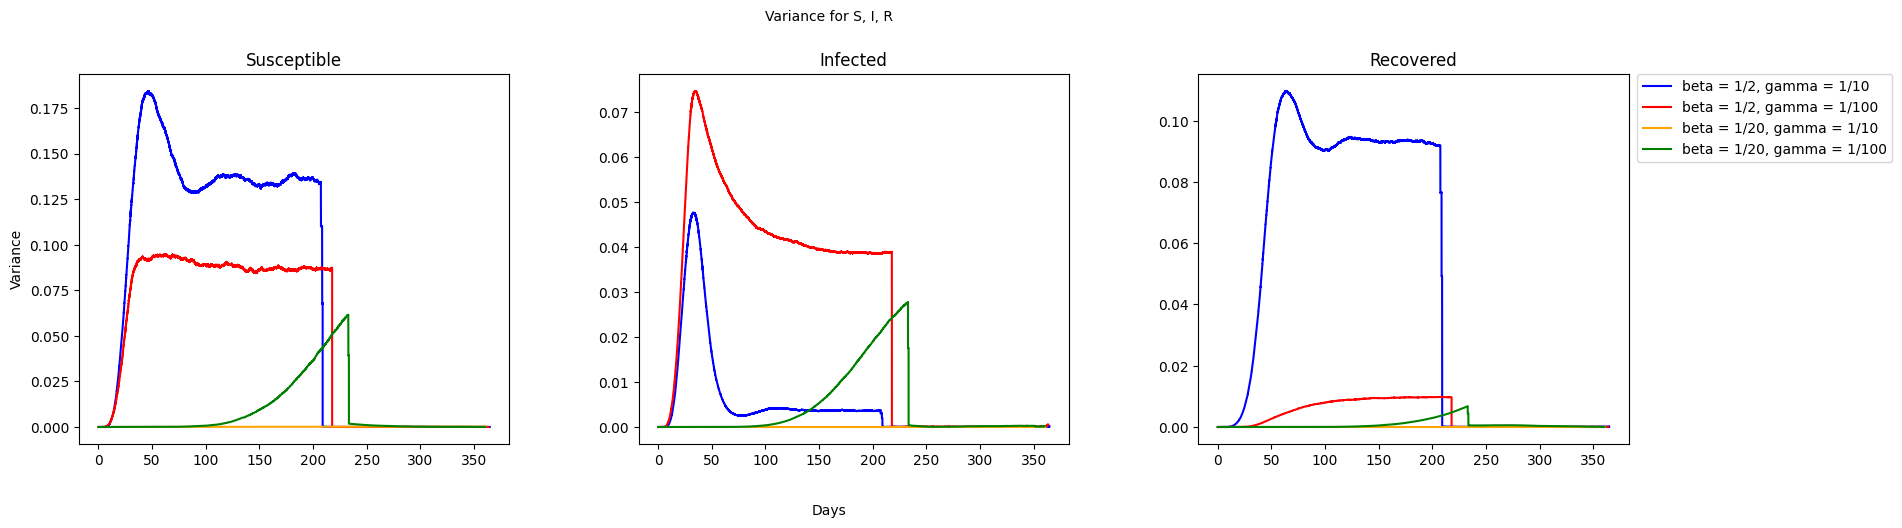

In [59]:
#Calculating Variance Between Runs
var_1s = concat_df_row_1["S"].var()
var_1i = concat_df_row_1["I"].var()
var_1r = concat_df_row_1["R"].var()

var_2s = concat_df_row_2["S"].var()
var_2i = concat_df_row_2["I"].var()
var_2r = concat_df_row_2["R"].var()

var_3s = concat_df_row_3["S"].var()
var_3i = concat_df_row_3["I"].var()
var_3r = concat_df_row_3["R"].var()

var_4s = concat_df_row_4["S"].var()
var_4i = concat_df_row_4["I"].var()
var_4r = concat_df_row_4["R"].var()

#Plotting Variance of Susceptibles over time across parameter conditions

fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})

fig.set_figwidth(20)

axs[0].plot(t1, var_1s, color = "blue")
axs[0].plot(t2, var_2s, color = "red")
axs[0].plot(t3, var_3s, color = "orange")
axs[0].plot(t4, var_4s, color = "green")
axs[0].set_ylabel("Variance")
axs[0].set_title("Susceptible")

axs[1].plot(t1, var_1i, color = "blue")
axs[1].plot(t2, var_2i, color = "red")
axs[1].plot(t3, var_3i, color = "orange")
axs[1].plot(t4, var_4i, color = "green")
axs[1].set_title("Infected")

axs[2].plot(t1, var_1r, color = "blue")
axs[2].plot(t2, var_2r, color = "red")
axs[2].plot(t3, var_3r, color = "orange")
axs[2].plot(t4, var_4r, color = "green")
axs[2].set_title("Recovered")

plt.legend(["beta = 1/2, gamma = 1/10", "beta = 1/2, gamma = 1/100", 
        "beta = 1/20, gamma = 1/10", "beta = 1/20, gamma = 1/100"], 
        bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

fig.text(0.5, -0.03, "Days", ha='center', va='center')
fig.text(0.5, 1.0, "Variance for S, I, R", ha='center', va='center', rotation='horizontal')
plt.subplots_adjust(wspace = 0.3)
plt.show()

In [ ]:
def extractFiles():
    allfiles = listdir("seeddata/")
    df = pd.DataFrame(pd.read_csv(f"seeddata/{allfiles[0]}"))
    for file in allfiles[1:]:
        new_df = pd.DataFrame(pd.read_csv(f"seeddata/{file}"))
        df = pd.concat([df, new_df])
    return df
data = extractFiles()
data.head()

## Stochastic Resonance and Increase Transients
> Show how the stochatic models can induce stochatic resonance around the equilibiruim and how that resonance relates to the paramters.

> Show some example of increased transients away from the deterministic equilibiruim. Which parameters lead to the largest transient?

## Extinction events and Critical Community Size
> Design an experiment that shows the effect of varying $R_0$ on the extinction process. *Keep in mind that int he closed system randomness will always eventually lead to extinction*. 

> Look at how the extinction events are impacted by the population size. Find a way to show how the two parameter $R_0$ and $N$ ineract to imact the extinction process.